Model has converged.


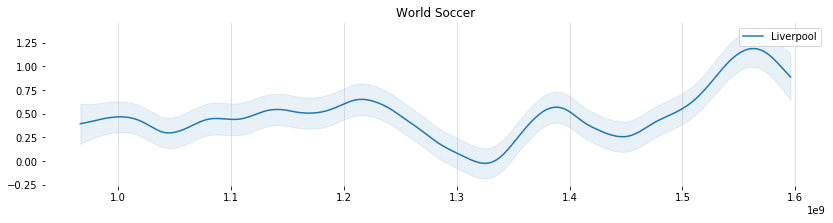

In [2]:

import kickscore as ks

from datetime import datetime
from dateutil.parser import parse

import sqlite3
from sqlite3 import Error



teams = set()
observations = list()
rows = []
cutoff = datetime(2020, 12, 1).timestamp()
conn = None
try:
    conn = sqlite3.connect('database.sqlite')
    cur = conn.cursor()
    cur.execute("SELECT Datetime, HomeTeam, AwayTeam, FTHG, FTAG FROM football_data Where HomeTeam = 'Liverpool' or AwayTeam = 'Liverpool' order by Datetime ASC")

    rows = cur.fetchall()
except Error as e:
    print(e)

for row in rows:
    t_date = datetime.strptime(row[0], "%Y-%m-%d %H:%M:%S")
    if datetime.strptime(row[0], "%Y-%m-%d %H:%M:%S") < parse('01/03/1970'):
        t = - (parse('01/03/1970') - datetime.strptime(row[0], "%Y-%m-%d %H:%M:%S")).days * 86400 + 25200 + parse(
            '01/03/1970').timestamp()
    else:
        t = datetime.strptime(row[0], "%Y-%m-%d %H:%M:%S").timestamp()
    #t = datetime.strptime(row[0], "%Y-%m-%d %H:%M:%S").timestamp()
    if t > cutoff:
        break
    teams.add(row[1])
    teams.add(row[2])
    if int(row[3]) > int(row[4]):
        observations.append({
            "winners": [row[1]],
            "losers": [row[2]],
            "t": t,
        })
    else:
        observations.append({
            "winners": [row[2]],
            "losers": [row[1]],
            "t": t,
        })
# It is a bit more convenient to specify lengthscales in yearly units.
seconds_in_year = 365.25 * 24 * 60 * 60

model = ks.BinaryModel()
kernel = (ks.kernel.Constant(var=0.03)
        + ks.kernel.Matern32(var=0.138, lscale=1.753*seconds_in_year))
for team in teams:
    model.add_item(team, kernel=kernel)

for obs in observations:
    model.observe(**obs)


converged = model.fit()
if converged:
    print("Model has converged.")
fig, ax = model.plot_scores(
        #items=["LAL", "CHI", "BOS"],
        items=["Liverpool"],
        resolution=10/seconds_in_year,
        figsize=(14.0, 3.0),
        timestamps=False)
ax.set_title("World Soccer");